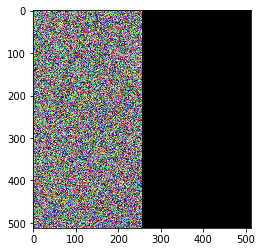

In [3]:
# Import numpy
import numpy as np
# Import some packages from matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Random map image
world_map = np.random.rand(512, 512, 3)
nrows, ncols, ncolors = world_map.shape

row, col, color = np.ogrid[:nrows, :ncols, :ncolors]

# Empty out the half of it
half_x = round(world_map.shape[1] / 2)
filtered_image = np.zeros_like(world_map[:, :, :])
filtered_image[:, :half_x, :] = world_map[:, :half_x, :]

# plt.imshow(world_map, cmap='gray',  interpolation='nearest')
plt.imshow(filtered_image)
plt.show()

In [1]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160), rgb_max=(255, 255, 255)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2]) \
                & (img[:,:,0] <= rgb_max[0]) \
                & (img[:,:,1] <= rgb_max[1]) \
                & (img[:,:,2] <= rgb_max[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

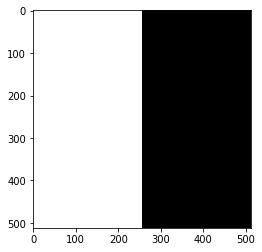

In [6]:
# Import numpy
import numpy as np
# Import some packages from matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Random map image
world_map_init = np.ones((512, 512), dtype=np.int)
nrows, ncols = world_map_init.shape

row, col = np.ogrid[:nrows, :ncols]

# Empty out the half of it
half_x = round(world_map_init.shape[1] / 2)
half_world_map_init = np.zeros_like(world_map_init[:, :])
half_world_map_init[:, :half_x] = world_map_init[:, :half_x]

plt.imshow(half_world_map_init, cmap='gray',  interpolation='nearest')
# plt.imshow(half_world_map_init)
plt.show()

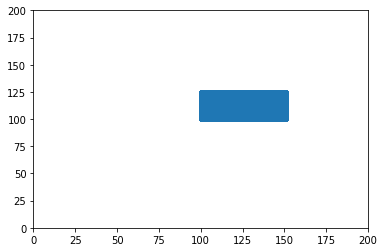

In [7]:
# Current position
xpos = 100
ypos = 100
yaw = 0
world_size = 200
scale = 10
# To rover coords
xpix, ypix = rover_coords(half_world_map_init)
# Convert rover-centric pixel values to world coords
x_pix_world, y_pix_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)
world_map = np.zeros((512, 512, 3), dtype=np.float32)
world_map[y_pix_world, x_pix_world, 0] += 1

# plt.imshow(world_map, cmap='gray',  interpolation='nearest')
plt.plot(x_pix_world, y_pix_world, '.')
plt.xlim(0, 200)
plt.ylim(0, 200)
# plt.imshow(world_map)
plt.show()


## Simulate world coordinates

[100 100 100 ..., 199 199 199]


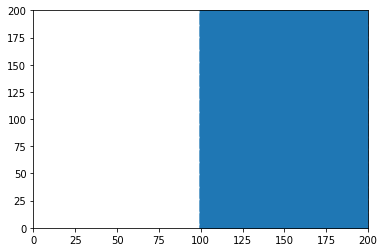

In [8]:
# Current position
xpos = 0
ypos = 0
yaw = 0
world_size = 200
scale = 10

# Build world map by pixels
x_pix_world = np.zeros((world_size**2), dtype=np.int)
y_pix_world = np.zeros_like(x_pix_world, dtype=np.int)

for i in range(0, x_pix_world.shape[0]):
    x_pix_world[i] = i / world_size
for i in range(0, world_size):
    for j in range(0, world_size):
        y_pix_world[i * world_size + j] = j
# print(x_pix_world)
# print(y_pix_world)
x_pix_world_filtered = x_pix_world[int(world_size ** 2 / 2):]
y_pix_world_filtered = y_pix_world[int(world_size ** 2 / 2):]
print(x_pix_world_filtered)
# print(y_pix_world)

# plt.plot(x_pix_world, y_pix_world, '.')
plt.plot(x_pix_world_filtered, y_pix_world_filtered, '.')
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.show()


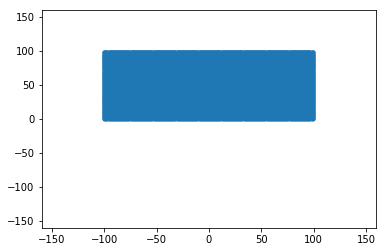

In [9]:
# Current position
xpos = 100
ypos = 100
yaw = 0
world_size = 200
scale = 1


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def world_to_rover(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix, ypix, -xpos, -ypos, scale)
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix_tran, ypix_tran, -yaw)
    # Perform rotation, translation and clipping all at once
#     x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
#     y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return xpix_rot, ypix_rot

x_pix_explored, y_pix_explored = world_to_rover(y_pix_world_filtered, x_pix_world_filtered, xpos, ypos, yaw, world_size, scale)

plt.plot(x_pix_explored, y_pix_explored, '.')
# plt.xlim(0, 160)
plt.xlim(-160, 160)
plt.ylim(-160, 160)
plt.show()


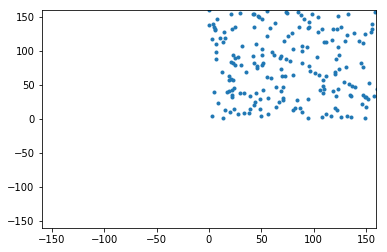

In [10]:
# Import numpy
import numpy as np
# Import some packages from matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Random map image
world_map = np.random.rand(512, 512, 3)
world_map_filtered = color_thresh(world_map, (0.8, 0.8, 0.8))
xpix, ypix = world_map_filtered.nonzero()

# plt.imshow(world_map_filtered, cmap='gray',  interpolation='nearest')
# plt.show()

plt.plot(xpix, ypix, '.')
# plt.xlim(0, 160)
plt.xlim(-160, 160)
plt.ylim(-160, 160)
plt.show()

## Convert vector arrays with useful pixel coordinates to matrix image

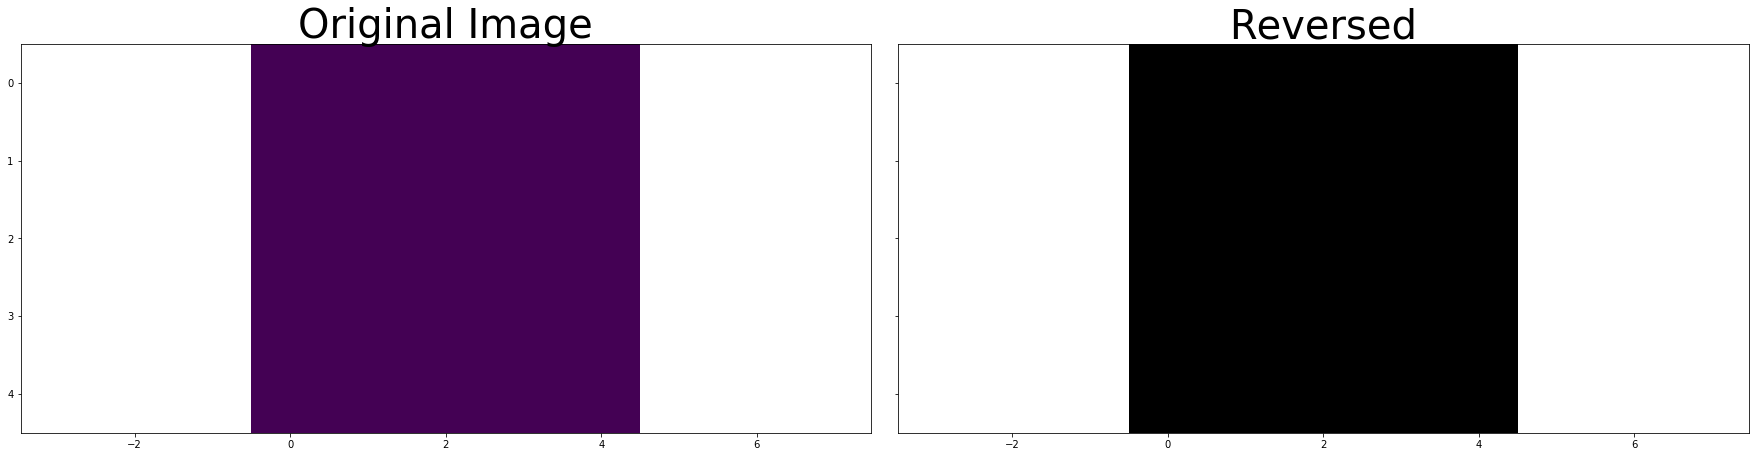

In [11]:
# Import numpy
import numpy as np
# Import some packages from matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Random map image
world_map = np.random.rand(5, 5, 3)
world_map_filtered = color_thresh(world_map, (0.7, 0.7, 0.7))
xpix, ypix = world_map_filtered.nonzero()

# plt.imshow(world_map_filtered, cmap='gray',  interpolation='nearest')
# plt.show()

mx = np.column_stack((xpix, ypix))
mx2 = np.zeros((world_map.shape[0], world_map.shape[1]), dtype = int)

for i in range(0, mx.shape[0]):
    mx2[mx[i][0], mx[i][1]] = 1

# plt.plot(xpix, ypix, '.')
# plt.xlim(0, world_map.shape[0])
# plt.ylim(0, world_map.shape[1])
# plt.show()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
f.tight_layout()
ax1.imshow(world_map_filtered)
ax1.set_title('Original Image', fontsize=40)

# ax2.plot(xpix, ypix, '.')
ax2.imshow(mx2, cmap='gray', interpolation='nearest')
# ax2.xlim(0, world_map.shape[0])
# ax2.ylim(0, world_map.shape[1])
ax2.set_title('Reversed', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() # Uncomment if running on your local machine

## Pix to world and back

----init------
[  0   0   0 ..., 511 511 511]
[ 83 295 423 ...,  10  66 140]
----rot0------
[  25.92985323   92.16032171  132.1485291  ...,  488.54753896  506.04237969
  529.16056209]
[  78.84568924  280.23467862  401.8280307  ..., -150.14094104  -96.94384951
  -26.64769284]
----tran0------
[ 102.26298532  108.88603217  112.88485291 ...,  148.5247539   150.27423797
  152.58605621]
[  93.47356892  113.61246786  125.77180307 ...,   70.5749059    75.89461505
   82.92423072]
----wmap------
[102 109 113 ..., 149 150 153]
[ 93 114 126 ...,  71  76  83]
----discovered------
[144 145 148 ..., 121 117 119]
[ 71  71  71 ..., 132 133 133]
----translated back------
[ 443.3  453.3  483.3 ...,  213.3  173.3  193.3]
[-145.89 -145.89 -145.89 ...,  464.11  474.11  474.11]
----rot back------
[ 466.68916057  476.1886412   504.68708309 ...,   57.63230522   16.510304
   35.50926526]
[ -9.75140661e-02   3.02656464e+00   1.23988007e+01 ...,   5.07516994e+02
   5.04520160e+02   5.10768318e+02]
----rev------
[

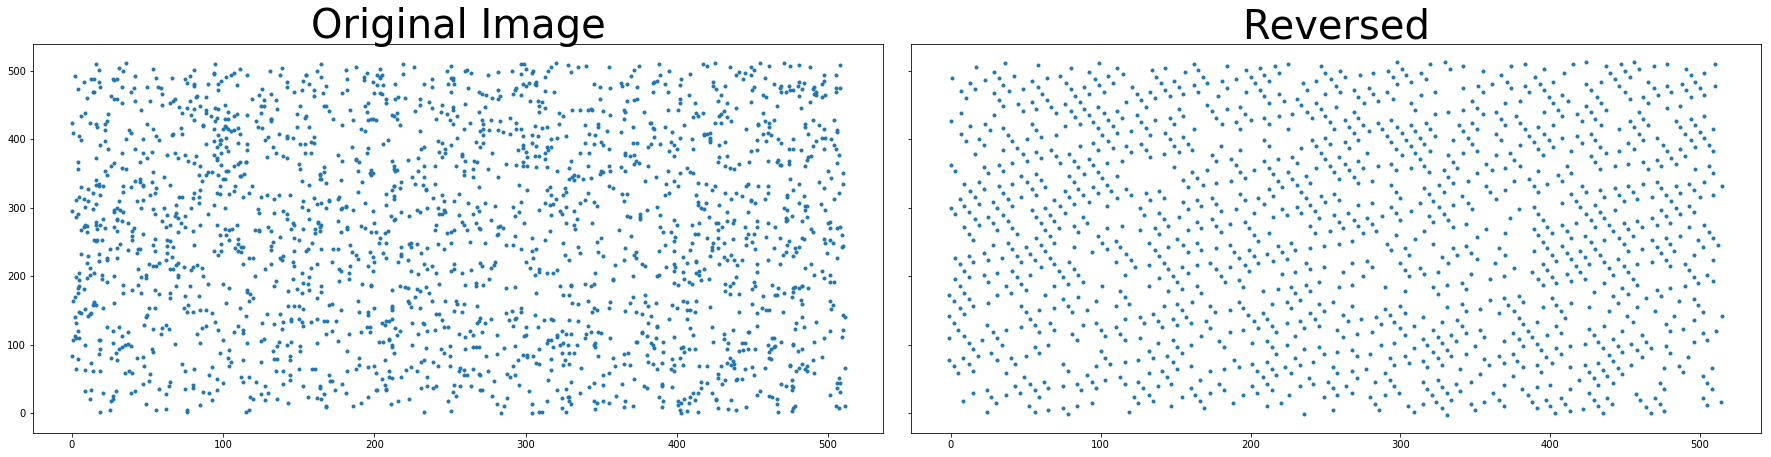

In [225]:
# Import numpy
import numpy as np
# Import some packages from matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)

    print('----rot0------')
    print(xpix_rot)
    print(ypix_rot)

    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)

    print('----tran0------')
    print(xpix_tran)
    print(ypix_tran)
    
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(np.round(xpix_tran)), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(np.round(ypix_tran)), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

def rotate_pix_reverse(xrot, yrot, yaw):
    yaw_rad = yaw * np.pi / 180
    xpix = xrot * np.cos(yaw_rad) + yrot * np.sin(yaw_rad)
    ypix = -xrot * np.sin(yaw_rad) + yrot * np.cos(yaw_rad)
    return xpix, ypix

# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def world_to_rover(w_map, xpos, ypos, yaw, world_size, scale, sensitivity_threshold = 0):
    map_discovered = np.zeros_like(w_map[:, :, 0])
    w_map_mask = w_map[:, :, 2] > sensitivity_threshold
    #  \
    #     | w_map[:, :, 1] > 0 \
    #     | w_map[:, :, 2] > 0
    map_discovered[w_map_mask] = 1
    ypix_discovered, xpix_discovered = map_discovered.nonzero()
    
    print('----discovered------')
    print(xpix_discovered)
    print(ypix_discovered)
    
    # Apply translation
    xpix_tran = (xpix_discovered - xpos) * scale
    ypix_tran = (ypix_discovered - ypos) * scale
    
    print('----translated back------')
    print(xpix_tran)
    print(ypix_tran)
    
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix_reverse(xpix_tran, ypix_tran, yaw)

    print('----rot back------')
    print(xpix_rot)
    print(ypix_rot)
    
    # Perform rotation, translation and clipping all at once
    x_pix_rov = np.int_(np.around(xpix_rot))
    y_pix_rov = np.int_(np.around(ypix_rot))
    # Return the result
    return x_pix_rov, y_pix_rov

# Current position
# xpos = 100
# ypos = 100
xpos = 99.67
ypos = 85.589
yaw = 341.7956
world_size = 200
scale = 10
worldmap = np.zeros((world_size, world_size, 3), dtype = int)

# Random map image
rover_view = np.random.rand(512, 512, 3)
rover_view_filtered = color_thresh(rover_view, (0.8, 0.8, 0.8))
xpix, ypix = rover_view_filtered.nonzero()

# xpix = np.array([101, 112, 123])
# ypix = np.array([98, 87, 73])

print('----init------')
print(xpix)
print(ypix)

x_pix_world, y_pix_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)
worldmap[y_pix_world, x_pix_world, 2] += 1

print('----wmap------')
print(x_pix_world)
print(y_pix_world)

x_pix_reversed, y_pix_reversed = world_to_rover(worldmap, xpos, ypos, yaw, world_size, scale)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Original Image', fontsize=40)

print('----rev------')
print(x_pix_reversed)
print(y_pix_reversed)

ax2.plot(x_pix_reversed, y_pix_reversed, '.')
ax2.set_title('Reversed', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() # Uncomment if running on your local machine

(2169,)
(1505, 2)
(1505, 1505)


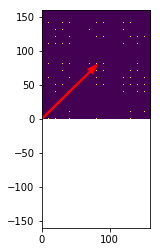

In [16]:
# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

rover_centric_pixel_distances_explored, rover_centric_angles_explored = \
        to_polar_coords(x_pix_reversed, y_pix_reversed)
mean_dir_explored = np.mean(rover_centric_angles_explored)

mx = np.column_stack((x_pix_reversed, y_pix_reversed))
mx2 = np.zeros((x_pix_reversed.shape[0], y_pix_reversed.shape[0]), dtype = int)
# mx = np.column_stack((xpix, ypix))
# mx2 = np.zeros((xpix.shape[0], ypix.shape[0]), dtype = int)

print(xpix.shape)
print(mx.shape)
for i in range(0, mx.shape[0]):
#     print (mx[i][0])
#     print (mx[i][1])
    mx2[mx[i][0]][mx[i][1]] = 1
print(mx2.shape)
    
# plt.plot(x_pix_reversed, y_pix_reversed, '.')
plt.imshow(mx2)
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir_explored)
y_arrow = arrow_length * np.sin(mean_dir_explored)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

## Draw circle

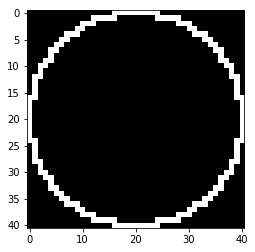

In [74]:
def draw_circle_points(points, radius, center):
    mx = np.zeros((radius * 2 + 1, radius * 2 + 1))
    slice = 2 * np.pi / points
    for i in range(0 , points):
        angle = slice * i;
        new_x = np.int_(round(center[0] + radius * np.cos(angle)))
        new_y = np.int_(round(center[1] + radius * np.sin(angle)))
        mx[new_x + radius - center[0], new_y + radius - center[1]] = 1
    return mx
        
radius = 20
mx = draw_circle_points(r*100, radius, (10, 0))

plt.imshow(mx, cmap='gray',  interpolation='nearest')
# plt.imshow(filtered_image)
plt.show()

## Circular mask

(768, 1024)
(768, 1024)


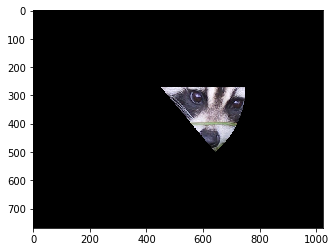

In [133]:
import numpy as np

def sector_mask(shape,centre,radius,angle_range):
    """
    Return a boolean mask for a circular sector. The start/stop angles in  
    `angle_range` should be given in clockwise order.
    Credits: https://stackoverflow.com/questions/18352973/mask-a-circular-sector-in-a-numpy-array
    """

    x,y = np.ogrid[:shape[0],:shape[1]]
    cx,cy = centre
    tmin,tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin
    
    print(r2.shape)
    print(theta.shape)

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)

    # circular mask
    circmask = r2 <= radius*radius

    # angular mask
    anglemask = theta <= (tmax-tmin)

    return circmask*anglemask

from matplotlib import pyplot as plt
from scipy.misc import face

matrix = face()
mask = sector_mask(matrix.shape,(270,450),300,(0,50))
matrix[~mask] = 0
plt.imshow(matrix)
plt.show()

## Arrays to image

[[0 1 1 1]
 [0 1 1 1]]
-----
[0 0 0 1 1 1] [1 2 3 1 2 3]
-----
[[ 0.  1.  1.  1.]
 [ 0.  1.  1.  1.]]
-----
True


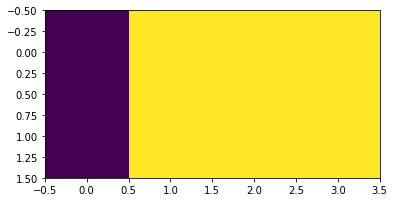

In [224]:
# mx = np.random.rand(5, 5)
mx = np.random.randint(2, size=(2, 4))
xpix, ypix = mx[:,:].nonzero()
print (mx)
print ('-----')
print (xpix, ypix)
print ('-----')

mx2 = np.zeros(mx.shape)
mx2[xpix, ypix] = 1

print(mx2)
print ('-----')

print((mx2 == mx).all())

plt.imshow(mx2)
plt.show()

## Enlarge point in square

[ 5 15]
[ 5 15  3 13  3 13  3 13  3 13  3 13  4 14  4 14  4 14  4 14  4 14  5 15  5
 15  5 15  5 15  6 16  6 16  6 16  6 16  6 16  7 17  7 17  7 17  7 17  7 17] [ 5 15  3 13  4 14  5 15  6 16  7 17  3 13  4 14  5 15  6 16  7 17  3 13  4
 14  6 16  7 17  3 13  4 14  5 15  6 16  7 17  3 13  4 14  5 15  6 16  7 17]


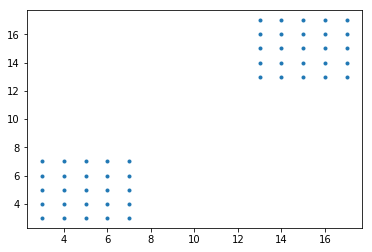

In [270]:
x = 5
y = 5
x_extend = 2
y_extend = 2
mx = np.zeros((20, 20))
mx[x, y] = 1
mx[10 + x, 10 + y] = 1

xres = xpix[:]
yres = ypix[:]
xpix, ypix = mx.nonzero()
print (xpix)
for i in range(-x_extend, x_extend + 1):
    for j in range(-y_extend, y_extend + 1):
        if i != 0 or j != 0:
            xres = np.concatenate((xres, xpix + i))
            yres = np.concatenate((yres, ypix + j))
    #         print(i, j)
    #         print(xres, yres)

print (xres, yres)
# plt.imshow(mx)
plt.plot(xres, yres, '.')
plt.show()

(20, 20)
(20, 20)
(20, 20)
(20, 20)
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.]
 [ 1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.]
 [ 1.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.]
 [ 1.  1.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.

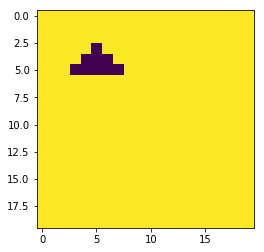

In [289]:
x = 5
y = 5
world_size = 2
scale = 10
mx = np.zeros((world_size * scale, world_size * scale))

yaw = 90
# x_pix_extended_180_back, y_pix_extended_180_back = sector_mask(
#     (world_size * scale, world_size * scale),
#     (x, y),
#     2,
#     (yaw + 90, yaw + 270)
# ).nonzero()

extended_mask = sector_mask(
    (world_size * scale, world_size * scale),
    (x, y),
    2,
    (yaw + 90, yaw + 270)
)

mx[~extended_mask] = 1
print (extended_mask.shape)
print (mx.shape)
print (mx)
plt.imshow(mx)
# plt.plot(x_pix_extended_180_back, y_pix_extended_180_back, '.')
plt.show()

## Difference of two coordinate lists

In [312]:
xpix_navigable = np.array([-100, 2, 3, 4, 5, 8])
ypix_navigable = np.array([-1, 2, 3, 4, 5, 6])
x_pix_explored = np.array([-3, 4])
y_pix_explored = np.array([-3, 4])

if x_pix_explored.shape[0] == 0:
    x_min = np.int_(min(xpix_navigable))
    x_max = np.int_(max(xpix_navigable))
    y_min = np.int_(min(ypix_navigable))
    y_max = np.int_(max(ypix_navigable))
else:
    x_max = np.int_(max(max(xpix_navigable), max(x_pix_explored)))
    x_min = np.int_(min(min(xpix_navigable), min(x_pix_explored)))
    y_max = np.int_(max(max(ypix_navigable), max(y_pix_explored)))
    y_min = np.int_(min(min(ypix_navigable), min(y_pix_explored)))
mx = np.zeros((x_max - x_min + 1, y_max - y_min + 1))
print(mx.shape)

mx[np.int_(xpix_navigable) - x_min, np.int_(ypix_navigable) - y_min] = 1
mx[np.int_(x_pix_explored) - x_min, np.int_(y_pix_explored) - y_min] = 0
x_pix_free, y_pix_free = mx.nonzero()
x_pix_free = x_pix_free + x_min
y_pix_free = y_pix_free + y_min
print(mx.nonzero()[0] + x_min, mx.nonzero()[1] + y_min)



(109, 10)
[-100    2    3    5    8] [-1  2  3  5  6]


In [19]:
nav_dists = [123]
min_value = None
if nav_dists != []:
    min_value = min(nav_dists)
print(min_value)

123


In [31]:
wm = np.random.rand(5, 5, 3)
wm_filtered = np.zeros_like(wm[:, :, :])
wm_filtered[2:4, 2:4, :] = wm[2:4, 2:4, :]
print(wm_filtered.shape)
print(wm_filtered)

(5, 5, 3)
[[[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.39919426  0.27738307  0.83016233]
  [ 0.30276025  0.71052536  0.12466134]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.64714778  0.44100846  0.42918087]
  [ 0.06792779  0.11804629  0.53920613]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

In [32]:
print(min(1, 2))

1


## Done
1. Display arrays as rover image
1. Code refactor
2. Store explored x, y positions
1. Enlarge reversed map points
3. Store explored x, y positions and its radius (180deg rear)
4. Extract explored from navigable

## Doing
1. Threshold of useful territory on free map

## Todo
5. Do not get stuck
    * overwrite order of nav view, extracted view (explored), close view
    * timeout in positioning
6. Collect rocks
7. Return to starting point